# Tutorial per a la Visualització de Mapes de Catalunya

Marc Bosch Manzano<br>
Octubre 2025

## Descripció de les Fonts de les Bases de Dades

Les dades complementàries descarregades han estat les següents:

- 1\. [Institut Cartogràfic i Geològic de Catalunya (ICGC)](https://www.icgc.cat/ca)<br>
  Un cop aquí anar a Geoinformació i mapes -> Geoinformació en Línia (Geoserveis) -> WMS i WFS Límits administratius.<br>

  - 1.1. [WMS Seccions censals](https://catalegs.ide.cat/geonetwork/srv/cat/catalog.search#/metadata/seccions-censals-v1r0-20240101)<br>
    Base de dades geogràfica que descriu la subdivisió dels municipis de Catalunya en districtes i seccions censals del 2024<br>
 
  - 1.2. [WMS i WFS Divisions administratives](https://catalegs.ide.cat/geonetwork/srv/cat/catalog.search#/metadata/divisions-administratives-v2r1-20250730)<br> 
    Base de dades geogràfica amb els límits geogràfics de municipis, comarques, vegueries, i províncies del 2025. Inclou un mapa de punts de municipis, els mapes que porten per nom "cap de municipi". Les escales de major a menor detall són 1:5 000 1:50 000, 1:100 000, 1:250 000, 1:500 000 i 1:1 000 000.<br>

- 2\. [Institut d'Estadística de Catalunya (IDESCAT)](https://www.idescat.cat/)<br>
  Un cop aquí, anar a Dades -> Dades bàsiques.<br>

  - 2.1. [Anuari estadístic de Catalunya](https://www.idescat.cat/indicadors/?id=basics)<br>
    Un cop aquí, anar aTaules Disponibles -> Medi Ambient Territori -> Territori -> Comarques i Municipis -> Altitud, superfície i població. 

    - 2.1.1. [Altitud, superfície i població. Municipis.](https://www.idescat.cat/indicadors/?id=aec&n=15903)<br>
      Directori amb totes les dades d'habitants per municipi per anys extretes d'IDESCAT.<br>
      Directori: *dades-poblacionals-per-municipi*<br>

  - 2.2. [Indicadors demogràfics i de territori](https://www.idescat.cat/pub/?id=inddt)<br>
    Un cop aquí, anar a Estructura per sexe i edats.<br>
    Aplicar el filtre de Selecció per nivell geogràfic de Municipis<br>

    - 2.2.1. [Estructura per sexe i edats. Homes.](https://www.idescat.cat/pub/?id=inddt&n=1957&t=202300)<br>

    - 2.2.2. [Estructura per sexe i edats. Dones.](https://www.idescat.cat/pub/?id=inddt&n=1958&t=202300)<br>

A partir de les webs consultades, hem creat els següents directoris:

```text
./catalonia-geography-maps
├───icgc
│   ├───divisions-administratives-v2r1-20250730
│   └───seccions-censals-20240101
└───idescat
    ├───altitud-superficie-poblacio-municipis
    └───estructura-per-sexe-i-edat-municipis
```

## Importacions de Llibreries i Definicions de Constants

En aquest notebook hem utilitzat les següents llibreries:

- pandas: Python Data Analysis Library<br>
- geopandas: Geographyc PANDAS<br>
- numpy: Numerical Python Library
- seaborn: Statistical Data Visualization
- import matplotlib.pyplot as plt
- matplotlib: Graphics Visualization with Python
  
S'instal·laran automàticament en el dispositiu si no es detecten instal·lades ja.

In [ ]:
PACKAGES = ["pandas", "geopandas", "numpy", "seaborn", "matplotlib"]
COLORS = ["viridis", "plasma", "inferno", "magma", "cividis"]

import os
import importlib
import sys
sys.path.append('../mobicat_python_utils')

import utils 
importlib.reload(utils)
utils.install_missing_packages(PACKAGES)

import seaborn as sns
import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt

Package pandas already installed.
Package geopandas already installed.
Package numpy already installed.
Package seaborn already installed.
Package matplotlib already installed.


## Importacions de les Dades Cartogràfiques de l'ICGC


`divisions-administratives-v2r1-20250730`

Hem escollit la realització més recent de les geometries, de l'any 2025. Tanmateix, existeixen més versions d'altres anys anteriors.

En la carpeta respectiva, teníem diversos documents per escollir. De mapes cartogràfics n'hi ha de sis categories: *caps municipi*, *catalunya*, *comarques*, *municipis*, *provincies*, i *vegueries*. Els fitxers de tipus *caps municipi* contenen el mapa de punts de les posicions dels ajuntaments dels municipis, mentre que els cinc tipus restants, en els seus fitxers contenen geometries dels límits administratius. De cada categoria, excepte *caps municipi*, hi hi ha sis escales per escollir en km2: 1:5.000, 1:50.000, 1:100.000, 1:250.000, 1:500.000, 1:1.000.000. De cada escala hi ha set fitxers amb les extensions següents: .cpg, .dbf, .prj, .sbn, .sbx, .shp, i .shx. També *caps municipi* té aquests set fitxers. Finalment, tenim un fitxer la pàgina web original en .html. En total tenim: $1 · 7 + 5 · 6 · 7 + 1 = 218$ fitxers en total. 


De tots els fitxers disponibles, els que són aptes per a visualitzar-se amb la llibreria Geopandas són les .shp. De totes les categories, la que ens centrarem és *municipi*. Aquesta conté les geometries que podrem aprofitar per les dades del repte de Mobilitat de Telefónica. Hem escollit la ràtio de 1:5.000 km2, la més fidel a les formes dels municipis. Totes les escales de *municipi* són relacions tabulars; els seus atributs els describim a continuació.

Atributs de la Relació de Municipis:

1. CODIMUNI: Codi de 6 dígits del municipi i identificador únic de la Generalitat de Catalunya. Els 5 primers 5 dígits són el codi de l'INE.
2. NOMMUNI: Nom oficial del municipi 
3. CAPMUNI: Nom oficial del cap de municipi (e.g. l'Hospitalet de Llobregat).
4. AREAM5000: Valor decimal de la superfície del municipi a escala 1:5000 en km2.
5. CODICOMAR: Codi de la comarca definit per la Generalitat de Catalunya.
6. NOMCOMAR: Nom de la comarca a què pertany el municipi.
7. CAPCOMAR: Nom del cap de la comarca.
8. CODIVEGUE: Codi de la vegueria a què pertany el municipi definit per la Generalitat de Catalunya.
9. NOMVEGUE: Nom oficial de la vegueria a què pertany el municipi.
10. CAPVEGUE: Nom del cap de la vegueria, si aquesta està aprovada; altrament, pren el valor "*".
11. CODIPROV: Codi de la província a què pertany el municipi.
12. NOMPROV: Nom oficial de la província a què pertany el municipi.
13. CAPPROV: Nom del cap de la província.
14. geometry: Geometria dels límits administratius dels municipis.

Veure més detall sobre els atributs a [Especificacions tècniques de Divisions administratives v2.1 (07.02.2025)](https://datacloud.ide.cat/especificacions/divisions-administratives-v2r1-20250207.pdf)

En el codi, també hem llegit les dades de *comarca*, *vegueria* i *província*, però de moment no les usarem. Ens centrarem amb les dades de municipi, desades a `municipi_data`.

In [7]:
maps_directory = r"./icgc/divisions-administratives-v2r1-20250730/"

map_file_names = {}
map_file_names["MUNICIPI"] = r"divisions-administratives-v2r1-municipis-5000-20250730.shp" 
map_file_names["COMARCA"] = r"divisions-administratives-v2r1-comarques-5000-20250730.shp"
map_file_names["VEGUERIA"] = r"divisions-administratives-v2r1-vegueries-5000-20250730.shp"
map_file_names["PROVINCIA"] = r"divisions-administratives-v2r1-provincies-5000-20250730.shp"

map_data = {}
for map, file_name in map_file_names.items():
    map_data[map] = gpd.read_file(os.path.join(maps_directory, file_name))

municipi_data = map_data["MUNICIPI"]
display(municipi_data.sample(5))

,CODIMUNI,NOMMUNI,CAPMUNI,AREAM5000,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,CODIPROV,NOMPROV,CAPPROV,geometry
183,081859,Rubió,Rubió,48.0000,06,Anoia,Igualada,08,Penedès,*,08,Barcelona,Barcelona,"POLYGON ((384869.64 4616895.112, 384911.52 461..."
858,430976,la Nou de Gaià,la Nou de Gaià,4.2977,36,Tarragonès,Tarragona,04,Camp de Tarragona,Tarragona,43,Tarragona,Tarragona,"POLYGON ((365566.7 4562378.3, 365559.853 45623..."
543,250122,Alcoletge,Alcoletge,16.7318,33,Segrià,Lleida,03,Lleida,Lleida,25,Lleida,Lleida,"POLYGON ((307878.343 4615521.413, 307914.233 4..."
251,082541,l'Esquirol,l'Esquirol,61.7969,24,Osona,Vic,07,Catalunya Central,*,08,Barcelona,Barcelona,"POLYGON ((450352.9 4659072.9, 450441.1 4658953..."
677,251689,el Poal,el Poal,8.8600,27,Pla d'Urgell,Mollerussa,03,Lleida,Lleida,25,Lleida,Lleida,"POLYGON ((321662.742 4617690.948, 321680.34 46..."


## Importacions de les Dades Demogràfiques de l'IDESCAT

`altitud-superficie-poblacio-municipis`

Dins d'aquesta caropeta, ens hem descarregat els fitxers dels anys 2021 al 2024 en .csv de la relació d'Altitud, Superfície i Població per Municipis de l'IDESCAT. En aquest cas, hem importat la relació del 2024, la més recent.

Atributs de la relació Altitud, Superfície i Població per Municipis:
- Municipi: Nom oficial del municipi, separant l'article amb coma (e.g. Hospitalet de Llobregat, l').
- Codi: Codi de 6 dígits del municipi i identificador únic de la Generalitat de Catalunya.
- Altitud: Un enter amb l'altitud en metres sobre el nivell del mar del municipi.
- Superfície: Un decimal amb la superfície a escala real del municipi en km2.
- Població: Un enter amb la població del municipi en l'any indicat.

Les dades importades les desemb al DataFrame de `population_data`.

In [6]:
population_directory = "./idescat/altitud-superficie-poblacio-municipis"
population_name = "t15903202400.csv"
population_path = os.path.join(population_directory, population_name)
population_data = pd.read_csv(population_path, sep=";", dtype=str, skiprows=5)

population_data["Superfície (km²)"] = population_data["Superfície (km²)"].apply(utils.to_float).astype("float")
population_data["Altitud (m)"] = population_data["Altitud (m)"].apply("int32")
population_data["Població"] = population_data["Població"].astype("int32")

display(population_data.sample(5))

,Municipi,Codi,Altitud (m),Superfície (km²),Població
584,Prats i Sansor,251752,1124,6.57,254
22,Alcarràs,250117,137,114.29,10217
515,"Palau d'Anglesola, el",251581,250,12.27,2200
475,Muntanyola,081290,807,40.30,712
99,Bellaguarda,251706,640,17.14,295


## Unió de les dades Geogràfiques amb les Demogràfiques dels Municipis

Aquí fem un inner join de `municipi_data` i `population_data`.

Prèviament, reanomenem totes les columnes de *population_data* per tal de fer coincidir els seus identificadors comuns: CODIMUNI. 

També, eliminem NOMMUMI de *municipi_data*. El motiu: el format del nom del municipi d'aquest dataframe no concorda amb el format de municipi de les dades de Telefónica. Necessitem el format que separa l'article del nom del municipi, en el cas dels municipis amb article (e.g. Hospitalet del Llobregat, l'). Eliminem també AREAM5000 de *municipi_data*, ja que necessitem la superfície real, de *population_data*.

Després del join, afegim la columna de densitat de població, usant POBLACIO i SUPERFICIE.

In [5]:
population_data.columns = ["NOMMUNI", "CODIMUNI", "ALTITUD", "SUPERFICIE", "POBLACIO"]
municipi_data_dropped = municipi_data.drop(["NOMMUNI", "AREAM5000"], axis=1)

municipi_population = population_data.join(
    other=municipi_data_dropped.set_index("CODIMUNI"),
    on="CODIMUNI",
    how="inner"
)

municipi_population["DENSITAT"] = municipi_population["POBLACIO"] / municipi_population["SUPERFICIE"]
municipi_population["DENSITAT"] = municipi_population["POBLACIO"] / municipi_population["SUPERFICIE"]
municipi_population = gpd.GeoDataFrame(municipi_population)

print(municipi_population.shape)
display(municipi_population.head(5))

(947, 17)


,NOMMUNI,CODIMUNI,ALTITUD,SUPERFICIE,POBLACIO,CAPMUNI,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,CODIPROV,NOMPROV,CAPPROV,geometry,DENSITAT
0,Abella de la Conca,250019,956,78.27,161,Abella de la Conca,25,Pallars Jussà,Tremp,06,Alt Pirineu,*,25,Lleida,Lleida,"POLYGON ((346678.012 4677003.965, 346688.593 4...",2.056982
1,Abrera,080018,105,19.94,12981,Abrera,11,Baix Llobregat,Sant Feliu de Llobregat,01,Barcelona,Barcelona,08,Barcelona,Barcelona,"POLYGON ((410315.5 4598888.5, 410888.8 4598869...",651.003009
2,Àger,250024,642,160.57,608,Àger,23,Noguera,Balaguer,03,Lleida,Lleida,25,Lleida,Lleida,"POLYGON ((308123.446 4660796.584, 308127.754 4...",3.786511
3,Agramunt,250030,337,79.65,5592,Agramunt,38,Urgell,Tàrrega,03,Lleida,Lleida,25,Lleida,Lleida,"MULTIPOLYGON (((342659.9 4635474.9, 342566.814...",70.207156
4,Aguilar de Segarra,080023,480,43.32,291,Aguilar de Segarra,07,Bages,Manresa,07,Catalunya Central,*,08,Barcelona,Barcelona,"POLYGON ((384322.708 4625199.422, 384343.603 4...",6.717452


## Visualitzacions de les Dades Cartogràfiques i Demogràfiques

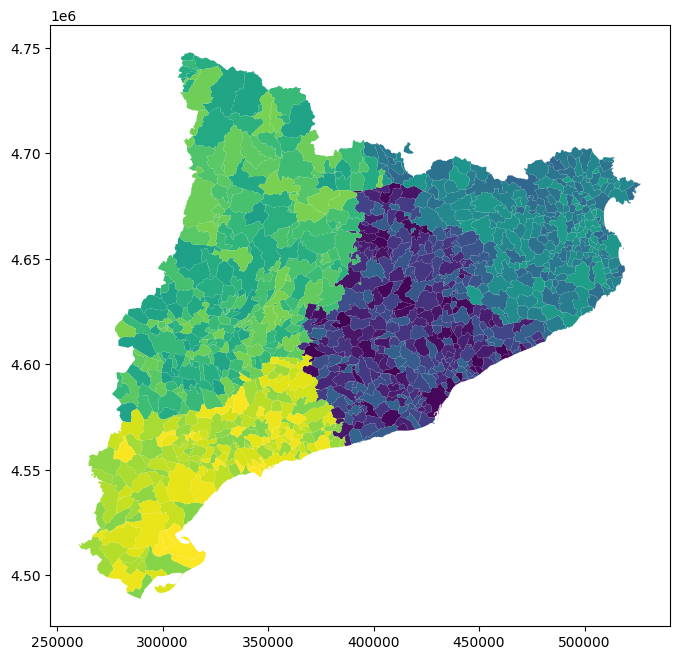

In [8]:
ax = municipi_data.plot(
    cmap=COLORS[0], 
    figsize=(8, 8)
)

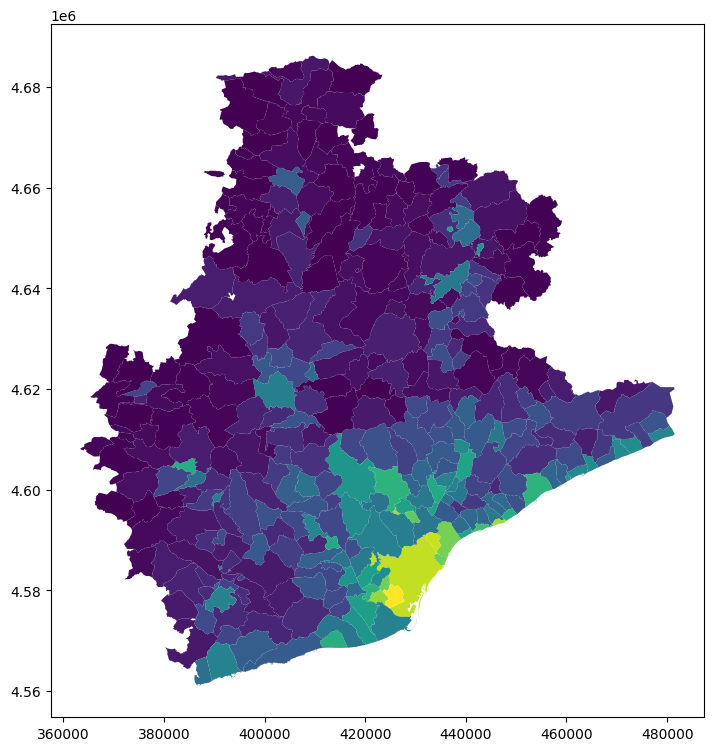

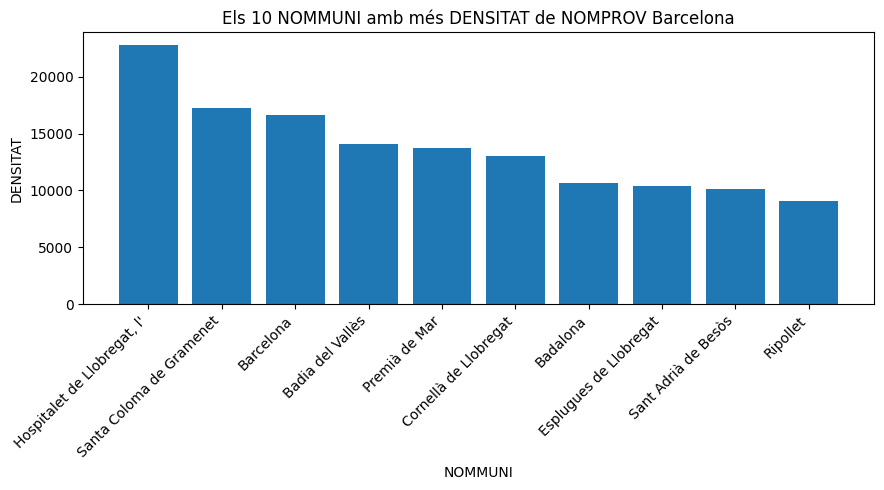

                         NOMMUNI CODIMUNI  ALTITUD  SUPERFICIE  POBLACIO  \
356  Hospitalet de Llobregat, l'   081017        8       12.40    282299   
742     Santa Coloma de Gramenet   082457       56        7.00    120903   
90                     Barcelona   080193        9      101.35   1686208   
79              Badia del Vallès   089045      120        0.93     13109   
588                Premià de Mar   081727        8        2.11     28928   
250        Cornellà de Llobregat   080734       27        6.99     91196   
78                      Badalona   080155        6       21.18    226219   
269       Esplugues de Llobregat   080771      110        4.60     47700   
653          Sant Adrià de Besòs   081944       14        3.82     38672   
621                     Ripollet   081803       79        4.33     39430   

                       CAPMUNI CODICOMAR           NOMCOMAR  \
356  l'Hospitalet de Llobregat        13         Barcelonès   
742   Santa Coloma de Gramenet       

In [17]:
selected_filter_vaule = "Barcelona"
selected_filter_descriptor = "NOMPROV"

selected_x_axis = "NOMMUNI"
selected_y_axis = "DENSITAT"

municipi_slected_province = municipi_population[municipi_population[selected_filter_descriptor] == selected_filter_vaule]

municipi_slected_province = gpd.GeoDataFrame(municipi_slected_province)
ax = municipi_slected_province.plot(
    column=np.log(municipi_slected_province[selected_y_axis])**3,
    figsize=(9,9)
)

num_top = 10
top_list = municipi_slected_province.sort_values(by=selected_y_axis, ascending=False).head(num_top)

plt.figure(figsize=(9,5))
plt.bar(top_list[selected_x_axis], top_list[selected_y_axis])

plt.title(f"Els {num_top} {selected_x_axis} amb més {selected_y_axis} de {selected_filter_descriptor} {selected_filter_vaule}")
plt.xlabel(F"{selected_x_axis}")
plt.ylabel(f"{selected_y_axis}")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

print(top_list)